# CNN Fashion MNIST Classification

Neste nootebook usaremos o conjunto de dados [MNIST Fashion](https://paperswithcode.com/dataset/fashion-mnist) composto por imagens em tons de cinza de dimensão 28×28, de 70.000 produtos de moda de 10 categorias diferentes, com 7.000 imagens por categoria. 

Nosso objetivo é criar um modelo que classifique uma determinada imagem em sua categoria.

Como de costume, vamos começar importando as bibliotecas necessárias:

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Carregamos os dados de treinamento:

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


A seguir, vamos checar alguns atributos do conjunto de dados.

O valor máximo existente:

In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

A forma dos dados:

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

Os **targets** (valores que desejamos prever).

Observe que eles estão codificados em números:

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

A seguir carregamos o conjunto de teste:

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(
  root = '.',
  train = False,
  transform = transforms.ToTensor(),
  download = True
)

Vejamos o número de classes que temos em nosso conjunto de dados:

In [7]:
K = len(set(train_dataset.targets.numpy()))
print(f"Número de classes: {K}")

Número de classes: 10


Como podemos confirmar acima, são 10 classes diferentes, cada uma representando uma categoria de produto de moda.

A seguir iremos definir o nosso modelo:

In [8]:
class CNN(nn.Module):
    def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

Instanciamos o modelo:

In [9]:
model = CNN(K)

A seguir definimos o mesmo modelo, porém dessa vez usando a recém-introduzida "Flatten" layer:

In [10]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(128 * 2 * 2, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, K)   
)

Instanciamos o modelo:

In [11]:
model = CNN(K)

Vamos mover o nosso modelo para o dispositivo de processamento que utilizaremos:

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Criamos a função Loss e o Optimizer:

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Definimos o **DataLoader**, ele é útil porque gera batches automaticamente no loop de treinamento e cuida também do embaralhamento:

In [14]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Vamos criar uma função que irá encapsular o loop de treinamento de nosso modelo:

In [15]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move os dados para o dispositivo de processamento
            inputs, targets = inputs.to(device), targets.to(device)

            # Zerar os parâmetros do gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward e optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Obtém o loss de treinamento e teste
        train_loss = np.mean(train_loss) 

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

E então executamos o treinamento:

In [16]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6662,       Test Loss: 0.4867, Duration: 0:00:25.978969
Epoch 2/15, Train Loss: 0.4422,       Test Loss: 0.4043, Duration: 0:00:26.286798
Epoch 3/15, Train Loss: 0.3874,       Test Loss: 0.3818, Duration: 0:00:26.338081
Epoch 4/15, Train Loss: 0.3521,       Test Loss: 0.3530, Duration: 0:00:26.166245
Epoch 5/15, Train Loss: 0.3251,       Test Loss: 0.3393, Duration: 0:00:26.414962
Epoch 6/15, Train Loss: 0.3054,       Test Loss: 0.3205, Duration: 0:00:26.303765
Epoch 7/15, Train Loss: 0.2846,       Test Loss: 0.3257, Duration: 0:00:26.489577
Epoch 8/15, Train Loss: 0.2681,       Test Loss: 0.3059, Duration: 0:00:26.514565
Epoch 9/15, Train Loss: 0.2526,       Test Loss: 0.3003, Duration: 0:00:26.497750
Epoch 10/15, Train Loss: 0.2381,       Test Loss: 0.2984, Duration: 0:00:26.409211
Epoch 11/15, Train Loss: 0.2259,       Test Loss: 0.2894, Duration: 0:00:26.480612
Epoch 12/15, Train Loss: 0.2151,       Test Loss: 0.2897, Duration: 0:00:26.481222
Epoch 13/15, 

Em seguida plotamos a loss de treinamento e teste por iteração:

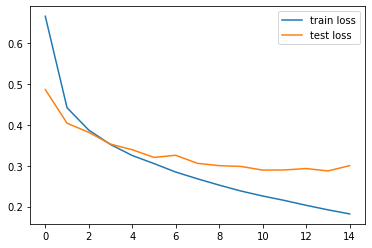

In [17]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

Também iremos calcular a **Accuracy** de treinamento e teste:

In [18]:
model.eval()

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # Movemos os dados para o dispositivo de processamento
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Obtemos previsões
    # torch.max retorna ambos max e argmax
    _, predictions = torch.max(outputs, 1)

    # Atualizamos os contadores
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Movemos os dados para o dispositivo de processamento
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Obtemos previsões
    # torch.max retorna ambos max e argmax
    _, predictions = torch.max(outputs, 1)

    # Atualizamos os contadores
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9503, Test acc: 0.8960


Definiremos uma função responsável por plotar a matriz de confusão:

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Obtemos todas as previsões em um array e plotamos a matriz de confusão:

Confusion matrix, without normalization
[[849   2  12  28   2   1 100   0   6   0]
 [  2 974   1  18   3   0   2   0   0   0]
 [ 22   0 789  12  67   0 109   0   1   0]
 [  9   6  10 917  37   0  18   0   3   0]
 [  0   0  45  27 831   0  95   0   2   0]
 [  0   0   0   0   0 966   0  21   1  12]
 [ 96   0  42  29  83   0 740   0  10   0]
 [  0   0   0   0   0  12   0 968   0  20]
 [  2   1   2   1   8   2   5   6 973   0]
 [  1   0   0   0   0   7   0  39   0 953]]


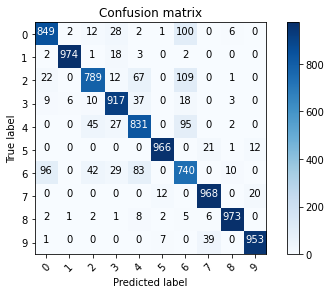

In [20]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # Movemos os dados para o dispositivo de processamento
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Obtemos previsões
    _, predictions = torch.max(outputs, 1)

    # Atualizamos p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

A seguir vamos definir uma string que será usadada para mapearmos os labels do dataset, de forma que possamos compreendê-los:

In [21]:
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

Por fim, apresentaremos algumas amostras que foram classificadas incorretamente:

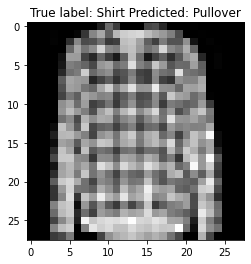

In [22]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));